## FORCAST Basic photometry
-------------------
**Aim**: Simple aperture photometry and uncertainty calculation. <br />
**Data**: FORCAST imaging data (5.6um) of the Symbiotic Mira, HM Sge <br />
**Tools**: astropy, photutils <br />
**Instrument**: FORCAST<br />
**Documentation**: [FORCAST data handbook](https://www.sofia.usra.edu/sites/default/files/USpot_DCS_DPS/Documents/FORCAST_data_handbook.pdf)

## Introduction
This turotial will go through the basic process of aperture photometry for a single source. The data used are Level 3 flux calibrated imaging data for a [public dataset](https://www.stsci.edu/hst/proposing/approved-programs/hst-sofia) targeting the Symbiotic Mira, HM Sge, in FORCAST's 5.6um filter. Access to this, and other, data can be found at the Infrared Science Archive [(IRSA)](https://irsa.ipac.caltech.edu/Missions/sofia.html). For further instructions on this process refer to the FORCAST data handbook referenced above.  

## Goals
* Determine the sum of the flux within an aperture .
* Determin the sum of flux within a larger annulus for background determination.
* Subtract background flux.

## Import packages

In [1]:
from astropy import units as u
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from photutils.aperture import (
    CircularAperture,
    CircularAnnulus,
    aperture_photometry,
)

## Load data

In [2]:
filename = "F0753_FO_IMA_7500575_FORF056_CAL_0109-0111.fits"
data = fits.open(filename)
hdr = data[0].header
w = WCS(data[0].header)

In [11]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  296                                                  
NAXIS2  =                  334                                                  
EXTEND  =                    T                                                  
COMMENT / -- scaling --                                                         
COMMENT / --- DCS OBSERVATION ---                                               
DATASRC = 'astro   '           / (DCS) data source                              
OBSTYPE = 'OBJECT  '           / Observation type                               
SRCTYPE = 'UNKNOWN '           / pipeline source type                           
KWDICT  = 'DCS_SI_rev_F'       / FITS keyword dictionary version                
OBS_ID  = 'P_2021-07-01_FO_F

In [3]:
# Aperture sum function
def get_aperture_sum(data, pos_pix, r_pix):
    pix_aperture = CircularAperture(pos_pix, r=r_pix)
    sum_aperture = aperture_photometry(data[0].data, pix_aperture)
    return sum_aperture["aperture_sum"], pix_aperture

## Get aperture radius sum
The background annulus should be as large as possible without including other sources or large variations to ensure good statistics. We recommend using the same aperture and annulus as used for calibrators (12 pixels). It is also recommended to use a background annulus of 15-25 pixels so long as this does not include additional sources of flux. 

```diff
- Warning: An aperture radius of 12 may not be appropriate for your observations.
```


In [4]:
# USER OPTIONS______________
r_ap = 12
background_aperture_inner_radius = 15.0
background_aperture_outter_radius = 25.0

target_ra = "19:41:57.080"
target_dec = "16:44:39.64"
# _________________________

In [5]:
# get position in SkyCoord format
pos = SkyCoord(target_ra, target_dec, unit=(u.hourangle, u.deg))
# convert to pixels within data
pos_pix = pos.to_pixel(w)
# determin sum flux
sum_jy, pix_aperture = get_aperture_sum(data, pos_pix, r_ap)

## Define background annulus

(<matplotlib.patches.PathPatch at 0x7fd9e3f47970>,)

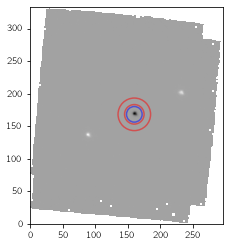

In [6]:
# get WCS information of data
w = WCS(data[0].header)
# define background annulus of similar center and specified radii
annulus_aperture = CircularAnnulus(
    pos_pix,
    r_in=background_aperture_inner_radius,
    r_out=background_aperture_outter_radius,
)
# plot aperture and annulus
plt.imshow(data[0].data, cmap="gray_r", origin="lower")
pix_aperture.plot(color="blue", lw=1.5, alpha=0.5)
annulus_aperture.plot(color="red", lw=1.5, alpha=0.5)

## Calculate and subtract background flux

In [7]:
# determine flux sum within background annulus
bkg_results = aperture_photometry(data[0].data, annulus_aperture)
# determine flux average in background annulus
bkg_mean = bkg_results["aperture_sum"] / annulus_aperture.area
# subtract background average from flux sum within aperture.
f0 = sum_jy[0] - bkg_mean[0]
print("Flux removed: " + "{:.6f}".format(bkg_mean[0]) + " Jy")
print("background_substracted flux: " + "{:.6f}".format(f0) + " Jy")

Flux removed: 0.001054 Jy
background_substracted flux: 52.810753 Jy


## Calculate uncertainty

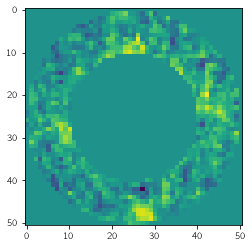

In [8]:
# create annulus mask from previous created annulus aperture
annulus_mask = annulus_aperture.to_mask(method="center")
# applying mask to data
annulus_data = annulus_mask.multiply(data[0].data)
# calculating standard deviation within background annulus
annulus_std = np.std(annulus_data)
# plotting data
plt.imshow(annulus_data)

In [9]:
# calculating absolute uncertainty
sigma_m = np.sqrt(
    (
        2 * np.pi * (r_ap * annulus_std / f0) ** 2
        + (hdr["ERRCALF"] / hdr["CALFCTR"]) ** 2
        + (0.0025)
    )
)

## Calculate final flux + uncertainty

In [10]:
uncertainty = sigma_m
print(
    "("
    + str(hdr["WAVELNTH"])
    + " um): "
    + "{:.6f}".format(f0)
    + " +/- "
    + "{:.6f}".format(uncertainty)
    + " Jy"
)

(5.6 um): 52.810753 +/- 0.055915 Jy
